In [21]:
import pandas as pd

In [22]:
training_df=pd.read_csv("../Datasets/training_df_raw.csv")
training_df.fillna(0,inplace=True)
training_df.drop(['date','time'],axis=1,inplace=True)
training_df.head()

,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,rain,snowfall,snow_depth,weather_code,pressure_msl,...,wind_gusts_10m,soil_temperature_0_to_7cm,soil_temperature_7_to_28cm,soil_temperature_28_to_100cm,soil_temperature_100_to_255cm,soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,soil_moisture_28_to_100cm,soil_moisture_100_to_255cm,fire
0,10.4600,95.42882,9.7600,9.326071,0.0,0.0,0.0,0.0,0.0,1012.4,...,11.879999,10.7600,13.110001,14.0100,21.910000,0.275,0.318,0.195,0.026,1
1,10.4535,95.42859,9.7535,9.317741,0.0,0.0,0.0,0.0,0.0,1012.4,...,11.879999,10.7535,13.103500,14.0035,21.903500,0.275,0.318,0.195,0.026,1
2,10.4145,95.42721,9.7145,9.267784,0.0,0.0,0.0,0.0,0.0,1012.4,...,11.879999,10.7145,13.064501,13.9645,21.864500,0.275,0.318,0.195,0.026,1
3,9.2235,99.66392,9.1735,8.143780,0.0,0.0,0.0,0.0,0.0,1012.5,...,13.320000,10.4235,12.823500,13.7235,21.923500,0.273,0.324,0.201,0.020,1
4,9.2430,99.66399,9.1930,8.168585,0.0,0.0,0.0,0.0,0.0,1012.5,...,13.320000,10.4430,12.842999,13.7430,21.942999,0.273,0.324,0.201,0.020,1


In [23]:
X=training_df.drop('fire',axis=1)
y=training_df['fire']

In [24]:
"""
Standard Scaling for the numerical variables cause every column is in different units - Centigrade, centimeter, millimeter etc
"""
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

def feature_transformation(encode_df):
    num_attributes=encode_df.columns.to_list()
    numeric_pipeline=Pipeline([
        ('std_scaler',StandardScaler())
    ])
    encoder_pipeline=ColumnTransformer([
        ("numeric_var",numeric_pipeline,num_attributes),
    ])
    df_encoded=encoder_pipeline.fit_transform(encode_df)
    return df_encoded,encoder_pipeline
X_transformed=feature_transformation(X)[0]

In [25]:
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV, train_test_split
from scipy.stats import randint
import lightgbm as lgb
import numpy as np

### K fold Cross Validation

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

In [27]:
lgbm = lgb.LGBMClassifier(random_state=42,n_jobs=-1)

In [28]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(lgbm, X_train, y_train, cv=kf, scoring='accuracy')
print(f"Mean Accuracy = {np.mean(scores):.4f}")

[LightGBM] [Info] Number of positive: 36315, number of negative: 36577
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005796 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5990
[LightGBM] [Info] Number of data points in the train set: 72892, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498203 -> initscore=-0.007189
[LightGBM] [Info] Start training from score -0.007189
[LightGBM] [Info] Number of positive: 36262, number of negative: 36631
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004520 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5985
[LightGBM] [Info] Number of data points in the train set: 72893, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497469 -> initscore=-0.010125
[LightGBM] [Info] Start training from score -0.010125
[Light

### Hyperparameter Tuning using Randomised Search CV

In [30]:
from scipy.stats import uniform,randint
param_dist = {
    'n_estimators': randint(50, 200),
    'learning_rate': uniform(0.01, 0.2),
    'num_leaves': randint(20, 100),
    'max_depth': randint(3, 12),
    'min_child_samples': randint(5, 50),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1)                   
}

random_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_dist,
    n_iter=100,
    scoring='accuracy',
    cv=5,
    random_state=42,               
    n_jobs=-1                      
)

random_search.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 45426, number of negative: 45690
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5993
[LightGBM] [Info] Number of data points in the train set: 91116, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498551 -> initscore=-0.005795
[LightGBM] [Info] Start training from score -0.005795
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


RandomizedSearchCV(cv=5, estimator=LGBMClassifier(n_jobs=-1, random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000234E36E00A0>,
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000234E36906D0>,
                                        'max_depth': <scipy.stats._distn...
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000234E36E2650>,
                                        'reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000234E3690250>,
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000234E36E1000>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000234B94A0790>},
                   random_state=42, scoring='accuracy')

In [37]:
random_search.best_params_

{'colsample_bytree': 0.8423839899124046,
 'learning_rate': 0.19526017570266982,
 'max_depth': 11,
 'min_child_samples': 32,
 'n_estimators': 184,
 'num_leaves': 92,
 'reg_alpha': 0.6232981268275579,
 'reg_lambda': 0.3308980248526492,
 'subsample': 0.6254233401144095}

In [41]:
lgbm=lgb.LGBMClassifier(colsample_bytree=random_search.best_params_['colsample_bytree'],
                        learning_rate=random_search.best_params_['learning_rate'],
                        max_depth=random_search.best_params_['max_depth'],
                        min_child_samples=random_search.best_params_['min_child_samples'],
                        n_estimators=random_search.best_params_['n_estimators'],
                        num_leaves=random_search.best_params_['num_leaves'],
                        reg_alpha=random_search.best_params_['reg_alpha'],
                        reg_lambda=random_search.best_params_['reg_lambda'],
                        subsample=random_search.best_params_['subsample'],
                        n_jobs=-1)
lgbm

LGBMClassifier(colsample_bytree=0.8423839899124046,
               learning_rate=0.19526017570266982, max_depth=11,
               min_child_samples=32, n_estimators=184, n_jobs=-1, num_leaves=92,
               reg_alpha=0.6232981268275579, reg_lambda=0.3308980248526492,
               subsample=0.6254233401144095)

### Training Light GBM

In [45]:
X_transformed=feature_transformation(X)[0]
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=23)
lgbm.fit(X_train,y_train)

[LightGBM] [Info] Number of positive: 45620, number of negative: 45496
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007980 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5995
[LightGBM] [Info] Number of data points in the train set: 91116, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500680 -> initscore=0.002722
[LightGBM] [Info] Start training from score 0.002722


LGBMClassifier(colsample_bytree=0.8423839899124046,
               learning_rate=0.19526017570266982, max_depth=11,
               min_child_samples=32, n_estimators=184, n_jobs=-1, num_leaves=92,
               reg_alpha=0.6232981268275579, reg_lambda=0.3308980248526492,
               subsample=0.6254233401144095)

In [46]:
y_pred=lgbm.predict(X_test)
y_scores = lgbm.predict_proba(X_test)[:, 1]

### Evaluation

In [47]:
from sklearn.metrics import (roc_auc_score, roc_curve, confusion_matrix,
                             ConfusionMatrixDisplay, classification_report)
import matplotlib.pyplot as plt
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.79      0.85     11452
           1       0.81      0.92      0.86     11328

    accuracy                           0.85     22780
   macro avg       0.86      0.85      0.85     22780
weighted avg       0.86      0.85      0.85     22780



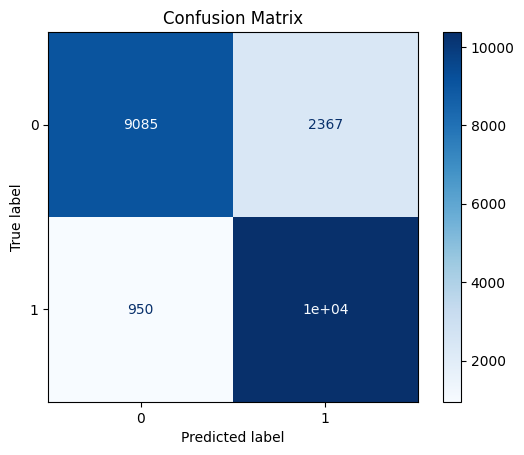

In [48]:
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

AUC-ROC Score: 0.9229921852953915


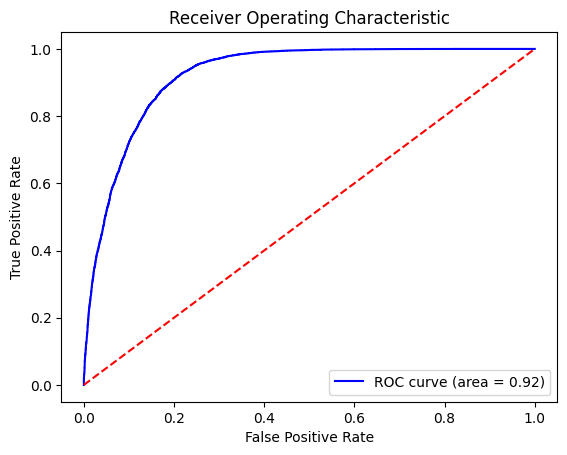

In [49]:
auc_score = roc_auc_score(y_test, y_scores)
print("AUC-ROC Score:", auc_score)


fpr, tpr, thresholds = roc_curve(y_test, y_scores)

plt.figure()
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()